# Classifying on real data


In [2]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import sys
import json
import matplotlib.pyplot as plt
import seaborn as sns
from master_scripts.data_functions import *
from master_scripts.analysis_functions import *
from master_scripts.plotting import plot_event
%load_ext autoreload
%autoreload 2
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data import

In [3]:
repo_root = get_git_root()
DATA_PATH = "../../data/real/anodedata_500k.txt"
DATA_FILENAME = "anodedata_500k.txt"
MODEL_PATH = "../../models/"
RESULTS_PATH = "../../results/"
CLASSIFIER = "4557cfeefc83.h5"


In [4]:
# Load experiment and associated model (must be a saved model instance complete with weights)
experiment_id = "4557cfeefc83"
experiment = load_experiment(experiment_id)
model = tf.keras.models.load_model(repo_root + "models/" + experiment_id + ".h5")
# Print experiment metrics
print("==== Experiment metrics")
print(json.dumps(experiment["metrics"], indent=2))
print("====")

==== Experiment metrics
{
  "accuracy_score": 0.9782421052631579,
  "confusion_matrix": {
    "TN": 236943,
    "FP": 589,
    "FN": 9746,
    "TP": 227722
  },
  "f1_score": 0.9778113654759016,
  "matthews_corrcoef": 0.9571957148197215,
  "roc_auc_score": 0.9924280110669701
}
====


In [17]:
events, images = import_real_data(DATA_PATH) # images not normalized
#images = normalize_image_data(images)

# load classification results (doesn't contain images)
with open(RESULTS_PATH + "events_classified_" + DATA_FILENAME[:-4] + "_" + CLASSIFIER[:-3] + ".json") as fp:
    events = json.load(fp)


In [6]:
descriptors = list([event['event_descriptor'] for event in events.values()])
print(descriptors.count(16))

17


In [7]:
# Extract doubles
doubles = []
ion_double_t = []
for event_id, event in events.items():
    if event['event_descriptor'] == 16:
        doubles.append(event_id)
    if event['event_descriptor'] == 12:
        ion_double_t.append(event_id)

In [8]:
print(len(doubles))

17


In [ ]:
# Plot the doubles and event_class from model
fig, axes = plt.subplots(6,3, figsize=(14,20), tight_layout=True)
idx = 0
for row in axes:
    for ax_col in row:
        if idx >= len(doubles):
            break
        curr_event = events[doubles[idx]]
        plot_event(curr_event, doubles[idx], images[curr_event['image_idx']], ax_col)
        idx += 1
#fig.savefig("test.pdf")
    
    

## Plot doubles in time

In [ ]:
# Light ions + double (time)
fig, axes = plt.subplots(2, 3, figsize=(12, 6), tight_layout=True)
idx = 0
for row in axes:
    for ax_col in row:
        if idx >= len(ion_double_t):
            break
        curr_event = events[ion_double_t[idx]]
        plot_event(curr_event, ion_double_t[idx], images[curr_event['image_idx']], ax_col)
        idx += 1
#fig.savefig("test.pdf")


# LIME analysis of select samples

In [12]:
from lime import lime_image

(1, 16, 16, 3)


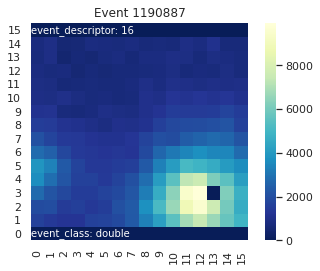

In [18]:
e_idx = '1190887'
image = images[events[e_idx]['image_idx']]
#image = images[events['1783487']['image_idx']]
#image = images[events['478726']['image_idx']]
# convert image to pseudo-rgb for LIME
image_conv = np.concatenate((image, image, image), axis=-1).astype(np.double).reshape(1, 16, 16, 3)
print(image_conv.shape)

ax = plot_event(events[e_idx], e_idx, image)

In [21]:
def new_predict_fn(images):
    "Custom predict function for LIME explanations"
    images = images[:,:, :, 0].reshape(images.shape[0], 16, 16, 1)
    return model.predict(normalize_image_data(images))

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(image_conv.reshape(16,16,3), new_predict_fn, top_labels=5, hide_color=0, num_samples=1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


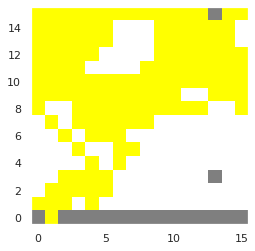

In [23]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.grid(None)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), origin='lower') 